In [2]:
#Question: How does changing the SRC Eigenmode ONLY effect the QM-limited Sensitivity?
#Question: How does changing the lensing of the beam coming from SRC effect the QM-limited Sensitivity?
####

In [3]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
from pykat.tools import modematching
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import matplotlib
import csv
import math
import numpy as np

### My functions
from kat_commands import *
from MMT import modematch
from cav_commands import *
import get_WS
import trace_mode

In [4]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

In [5]:
####  No squeezing here.

#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands)
basekat.parseCommands(amplitude_detectors)
basekat.parseCommands(pds)
basekat.parseCommands("maxtem "+str(2))
basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

SRMHR_Rc_orig = kat.SRMHR.Rc.value

#out_perfect_mm_trace = kat.run(getTraceData=True)

In [6]:
SRCTL_q_perfect_x = out_perfect_mm["SRCoutx"] #q's coming out of the SRC @ the OFI
SRCTL_q_perfect_y = out_perfect_mm["SRCouty"]

SRMY_q_perfect_x = out_perfect_mm["SRMYqx"] #q's at the face of SRMHR
SRMY_q_perfect_y = out_perfect_mm["SRMYqy"]

In [7]:
###
###Extract the eigenmode of SRC with offsets in SRMHR
###

SRMRoc_offset = []
max_offset = .5 #50cm Roc change in SRM curvature
steps = 5

### modulated q's at the face of SRMHR
SRMY_q1_x_list = []
SRMY_q1_y_list = []

### the q's @ nPRBS w/ resp to the SRMY Eigenmode
q_BS_SRCY_x = []
q_BS_SRCY_y = []

### the q's @ nPRBS w/ resp to the ITMY Eigenmode
q_BS_ITMY_x = []
q_BS_ITMY_y = []

### the q's @ nPRBS w/ resp to the OMC Eigenmode
q_BS_OMC_x = []
q_BS_OMC_y = []

### overlaps
overlap_SRC_to_ARM_x = []
overlap_SRC_to_ARM_y = []

overlap_OMC_to_ARM_x = []
overlap_OMC_to_ARM_y = []

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]

get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []


for i in range(0,steps,1):
    dRc = (float(i)/steps) * max_offset
    SRMRoc_offset.append(dRc)
    
    #Add Commands
    basekat1 = pykat.finesse.kat() 
    basekat1.loadKatFile(katfile)
    basekat1.parseCommands(commands)
    basekat1.parseCommands(amplitude_detectors)
    basekat1.parseCommands(pds)
    basekat1.undumpNodes()
    kat1=basekat1.deepcopy() 
    kat1.verbose = False
    
    # Change the SRMHR_Roc
    SRMHR_Rc_new = SRMHR_Rc_orig + dRc
    kat1.SRMHR.Rcx.value = SRMHR_Rc_new
    kat1.SRMHR.Rcy.value = SRMHR_Rc_new

    #Run and extract the q's at the OFI and SRMHR
    out_new_SRM_roc = kat1.run()
    SRCTL_q1_x = out_new_SRM_roc["SRCoutx"]
    SRCTL_q1_y = out_new_SRM_roc["SRCouty"]
    SRMY_q1_x = out_new_SRM_roc["SRMYqx"]
    SRMY_q1_y = out_new_SRM_roc["SRMYqy"]
    SRMY_q1_x_list.append(SRMY_q1_x)
    SRMY_q1_y_list.append(SRMY_q1_y)

    #### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
    [srcx,srcy] = trace_mode.from_cav_to_BS(kat1,'cavSRY')
    q_BS_SRCY_x.append(srcx)
    q_BS_SRCY_y.append(srcy)

    #### Turn off all the cav commands except XARM to extract the eigenmode at the BS
    [ARMx,ARMy] = trace_mode.from_cav_to_BS(kat1,'cavXARM')
    q_BS_ITMY_x.append(ARMx)
    q_BS_ITMY_y.append(ARMy)

    #### Turn off all the cav commands except OMC to extract the eigenmode at the BS
    [OMCx,OMCy] = trace_mode.from_cav_to_BS(kat1,'cavOMC')
    q_BS_OMC_x.append(OMCx)
    q_BS_OMC_y.append(OMCy)

    overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
    overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))

    overlap_OMC_to_ARM_x.append(pykat.beam_param.overlap(OMCx,ARMx))
    overlap_OMC_to_ARM_y.append(pykat.beam_param.overlap(OMCy,ARMy))


    #### Extract the mode at the SRMAR w.r.t the ARM
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavXARM.enabled = True
    kat1.cavYARM.enabled = True

    get_SRM_q_wrt_cavARM = kat1.run(getTraceData=True)
    get_SRM_qx_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][0]._gauss_param__q)
    get_SRM_qy_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][1]._gauss_param__q)


    #### Extract the mode at the OFI w.r.t the OMC
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavOMC.enabled = True
    get_OFI_qx_wrt_OMC = kat1.run(getTraceData=True)
    get_OFI_qx_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][0]._gauss_param__q))
    get_OFI_qy_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][1]._gauss_param__q))


q_refin_x_list = get_SRM_qx_wrt_cavARM_list
q_refin_y_list = get_SRM_qy_wrt_cavARM_list

q_refout_x_list = get_OFI_qx_wrt_OMC_list
q_refout_y_list = get_OFI_qy_wrt_OMC_list

In [8]:
# Finally, we use the q_in and q_out to create an anti-lensing effect with a telescoping array between
# the SRM and OFI
darm_list = []
freq = []

SRCTL_q3_x_list = []
SRCTL_q3_y_list = []

SRMY_q3_x_list =[]
SRMY_q3_y_list =[]

for i in range(0,steps,1):
    basekat3 = pykat.finesse.kat() 
    basekat3.loadKatFile(katfile)
    basekat3.parseCommands(darm_commands)
    basekat3.parseCommands(amplitude_detectors)
    basekat3.parseCommands("maxtem "+str(4))
    basekat3.parseCommands(pds)
    basekat3.undumpNodes()
    kat3=basekat3.deepcopy()
    kat3.verbose = False
    
    SRMHR_Rc = kat.SRMHR.Rc
    dRc = SRMRoc_offset[i]
    
    kat3.SRMHR.Rcx.value = SRMHR_Rc + dRc
    kat3.SRMHR.Rcy.value = SRMHR_Rc + dRc

    #
    #    q1   d1   f1  d2   f2  d3   q2
    #    |   <-->  |  <-->  | <-->  |
    #    | <---------- D ---------> |
    #

    q1 = q_refin_x_list[i]
    q2 = q_refout_x_list[i]
    D  = 0.491516 # total distance from SRC to OFI
    d1 = 0.25
    d2 = 0.0001
    d3 = D-d1-d2

    [f1, f2] = modematch(q1, q2, d1, d2, d3)

    kat3.lSRMTT1.L.value = d1
    kat3.SRMTT1.f.value = f1
    kat3.lSRMTT2.L.value = d2
    kat3.SRMTT2.f.value = f2
    kat3.lIBAin.L.value = d3

    out3 = kat3.run()

    SRCTL_q3_x = out3["SRCoutx"]
    SRCTL_q3_y = out3["SRCouty"]

    SRMY_q3_x = out3["SRMYqx"]
    SRMY_q3_y = out3["SRMYqy"]


    SRCTL_q3_x_list.append(SRCTL_q3_x)
    SRMY_q3_x_list.append(SRMY_q3_x)

    freq.append(out3.x)
    darm_list.append(out3['NSR_with_RP'])


Successfully Mode-Matched! >99.9% overlap
f1 is 0.3696317498932183
f2 is -0.36950886580337755
Successfully Mode-Matched! >99.9% overlap
f1 is -0.5244020611323619
f2 is 0.5249339558495397
Successfully Mode-Matched! >99.9% overlap
f1 is -0.1494396738948437
f2 is 0.14960722058466536
Successfully Mode-Matched! >99.9% overlap
f1 is -0.08577326992065325
f2 is 0.08590662894495198
Successfully Mode-Matched! >99.9% overlap
f1 is -0.059458370214361754
f2 is 0.059579944249805845


In [20]:
#### Get overlaps in the final state

f_overlap_SRC_to_ARM_x = []
f_overlap_SRC_to_ARM_y = []

f_overlap_OMC_to_ARM_x = []
f_overlap_OMC_to_ARM_y = []

f_overlap_OMC_to_SRC_x = []
f_overlap_OMC_to_SRC_y = []

f1_list = []
f2_list = []

### the q's @ nPRBS w/ resp to the SRMY Eigenmode
f_q_BS_SRCY_x = []
f_q_BS_SRCY_y = []

### the q's @ nPRBS w/ resp to the ITMY Eigenmode
f_q_BS_ITMY_x = []
f_q_BS_ITMY_y = []

### the q's @ nPRBS w/ resp to the OMC Eigenmode
f_q_BS_OMC_x = []
f_q_BS_OMC_y = []

for i in range(0,steps,1):
    basekat3 = pykat.finesse.kat() 
    basekat3.loadKatFile(katfile)
    basekat3.parseCommands(commands)
    basekat3.parseCommands(amplitude_detectors)
    basekat3.parseCommands(pds)
    basekat3.parseCommands(add_squeezing)
    basekat3.parseCommands("maxtem "+str(2))
    basekat3.undumpNodes()
    kat3=basekat3.deepcopy()
    kat3.verbose = False
    
    SRMHR_Rc = kat.SRMHR.Rc
    dRc = SRMRoc_offset[i]

    kat3.SRMHR.Rcx.value = SRMHR_Rc + dRc
    kat3.SRMHR.Rcy.value = SRMHR_Rc + dRc

        #
    #    q1   d1   f1  d2   f2  d3   q2
    #    |   <-->  |  <-->  | <-->  |
    #    | <---------- D ---------> |
    #

    q1 = q_refin_x_list[i]
    q2 = q_refout_x_list[i]
    D  = 0.491516 # total distance from SRC to OFI
    d1 = 0.25
    d2 = 0.0001
    d3 = D-d1-d2

    [f1, f2] = modematch(q1, q2, d1, d2, d3)

    kat3.lSRMTT1.L.value = d1
    kat3.SRMTT1.f.value = f1
    kat3.lSRMTT2.L.value = d2
    kat3.SRMTT2.f.value = f2
    kat3.lIBAin.L.value = d3

    #### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
    [srcx,srcy] = trace_mode.from_cav_to_BS(kat3,'cavSRY')
    f_q_BS_SRCY_x.append(srcx)
    f_q_BS_SRCY_y.append(srcy)
    

    #### Turn off all the cav commands except YARM to extract the eigenmode at the BS
    [ARMx,ARMy] = trace_mode.from_cav_to_BS(kat3,'cavXARM')
    f_q_BS_ITMY_x.append(ARMx)
    f_q_BS_ITMY_y.append(ARMy)
    
    
    #### Turn off all the cav commands except OMC to extract the eigenmode at the BS
    [OMCx,OMCy] = trace_mode.from_cav_to_BS(kat3,'cavOMC')
    f_q_BS_OMC_x.append(OMCx)
    f_q_BS_OMC_y.append(OMCy)

    f_overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
    f_overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))

    f_overlap_OMC_to_ARM_x.append(pykat.beam_param.overlap(OMCx,ARMx))
    f_overlap_OMC_to_ARM_y.append(pykat.beam_param.overlap(OMCy,ARMy))

    f_overlap_OMC_to_SRC_x.append(pykat.beam_param.overlap(OMCx,srcx))
    f_overlap_OMC_to_SRC_y.append(pykat.beam_param.overlap(OMCy,srcy))

    f1_list.append(f1)
    f2_list.append(f2) 

Successfully Mode-Matched! >99.9% overlap
f1 is 0.3696317498932183
f2 is -0.36950886580337755
Successfully Mode-Matched! >99.9% overlap
f1 is -0.5244020611323619
f2 is 0.5249339558495397
Successfully Mode-Matched! >99.9% overlap
f1 is -0.1494396738948437
f2 is 0.14960722058466536
Successfully Mode-Matched! >99.9% overlap
f1 is -0.08577326992065325
f2 is 0.08590662894495198
Successfully Mode-Matched! >99.9% overlap
f1 is -0.059458370214361754
f2 is 0.059579944249805845


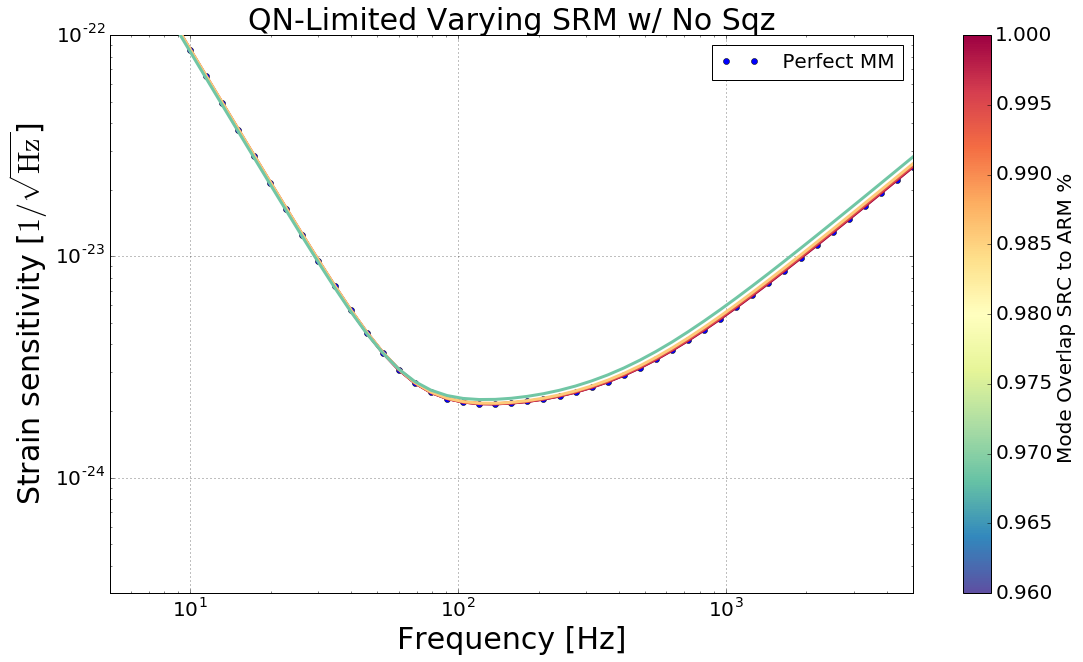

In [10]:
pl.figure(figsize=(18, 10), dpi=80)

cm = pl.cm.Spectral_r
norm = matplotlib.colors.Normalize(0.96, 1.0)

s_m = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
s_m.set_array([])


for i in range(len(darm_list)):
    c = c = s_m.to_rgba(overlap_SRC_to_ARM_x[i])
    pl.subplot(111)
    pl.loglog(freq[0], np.real(darm_list[i]),linewidth=3,zorder=1000, color = c,)

pl.loglog(out_perfect_mm.x, np.real(out_perfect_mm['NSR_with_RP']),'o',label=' Perfect MM')

pl.title("QN-Limited Varying SRM w/ No Sqz",fontsize=30)
pl.xlim(freq[0].min(),freq[0].max())
pl.ylim(3e-25,1e-22)
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

###Colorbar formatting
cb = pl.colorbar(s_m)
cb.set_label("Mode Overlap SRC to ARM % ", fontsize = 20)
cb.ax.tick_params(labelsize=20) 
cb.update_ticks()

pl.savefig("ht_varyingSRM_wNoSqz.eps")

pl.show()

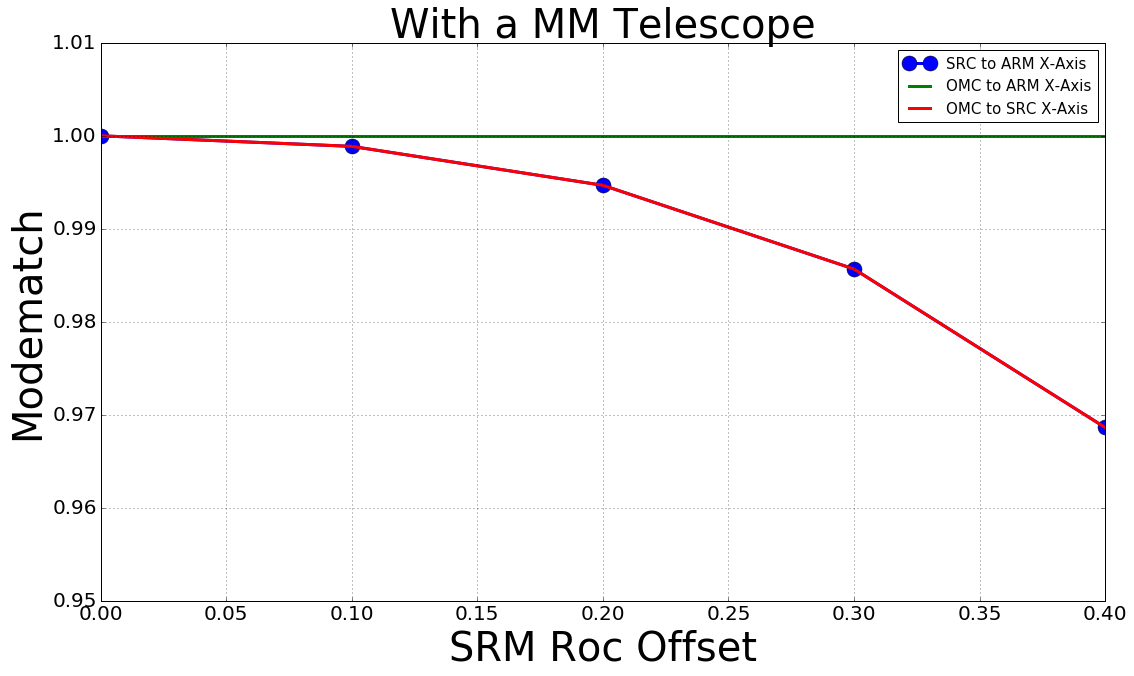

In [11]:
pl.figure(figsize=(18, 10), dpi=80)

pl.title("With a MM Telescope",fontsize=40)

pl.plot(SRMRoc_offset, f_overlap_SRC_to_ARM_x,'o-',markersize=15,linewidth=3, label='SRC to ARM X-Axis')
pl.plot(SRMRoc_offset, f_overlap_OMC_to_ARM_x,linewidth=3, label='OMC to ARM X-Axis')
pl.plot(SRMRoc_offset, f_overlap_OMC_to_SRC_x,linewidth=3, label='OMC to SRC X-Axis')


pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.xlim(min(SRMRoc_offset),max(SRMRoc_offset))
pl.ylim(.95,1.01)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

pl.xlabel("SRM Roc Offset",fontsize=40)
pl.ylabel("Modematch",fontsize=40)

pl.savefig("MMvsSRMoffset_w_MMTT_noSqz.eps")

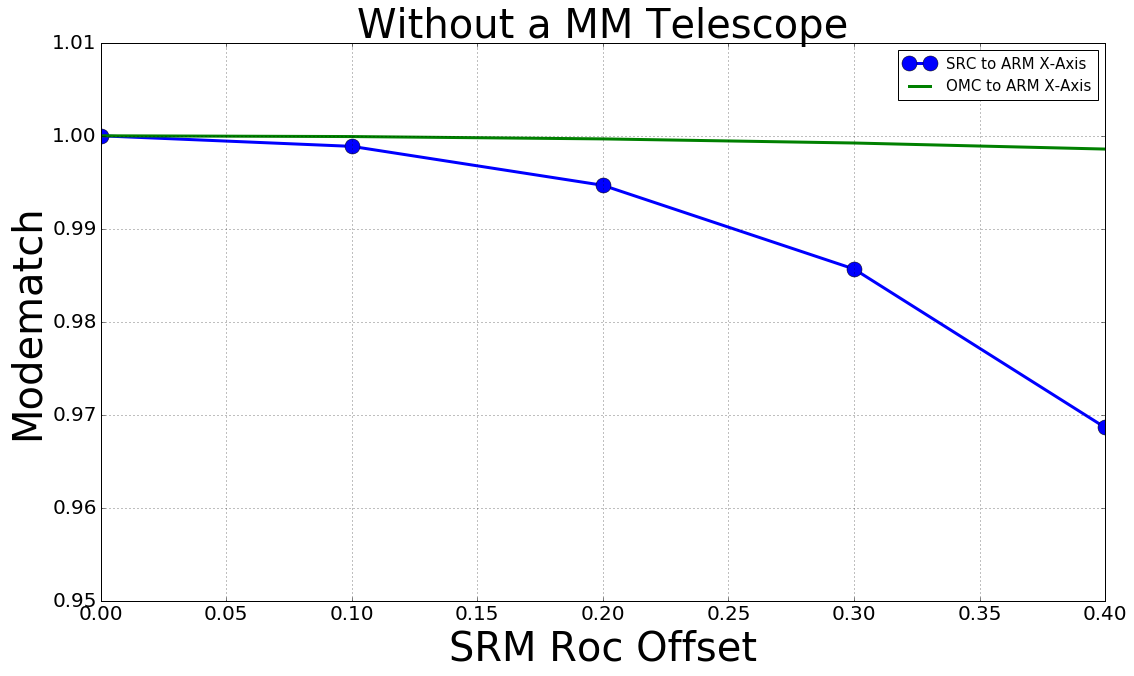

In [12]:
pl.figure(figsize=(18, 10), dpi=80)

pl.title("Without a MM Telescope",fontsize=40)

pl.plot(SRMRoc_offset, overlap_SRC_to_ARM_x,'o-',markersize=15,linewidth=3, label='SRC to ARM X-Axis')
pl.plot(SRMRoc_offset, overlap_OMC_to_ARM_x,linewidth=3, label='OMC to ARM X-Axis')

pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.xlim(min(SRMRoc_offset),max(SRMRoc_offset))
pl.ylim(.95,1.01)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

pl.xlabel("SRM Roc Offset",fontsize=40)
pl.ylabel("Modematch",fontsize=40)

pl.savefig("MMvsSRMoffset_wo_MMTT_noSqz.eps")

In [22]:
### beamsize is in mm and defocus is in microdipoters (no MM)
SRC_wx, SRC_wy, SRC_sx, SRC_sy = get_WS.phase_space(q_BS_SRCY_x,q_BS_SRCY_y)
OMC_wx, OMC_wy, OMC_sx, OMC_sy = get_WS.phase_space(q_BS_OMC_x,q_BS_OMC_y)

### beamsize is in mm and defocus is in microdipoters (w/ MM)
f_SRC_wx, f_SRC_wy, f_SRC_sx, f_SRC_sy = get_WS.phase_space(f_q_BS_SRCY_x,f_q_BS_SRCY_y)
f_OMC_wx, f_OMC_wy, f_OMC_sx, f_OMC_sy = get_WS.phase_space(f_q_BS_OMC_x,f_q_BS_OMC_y)

In [1]:
pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(111)

pl.plot(SRC_wx,SRC_sx,'o', markersize = 10,label='SRC')
pl.plot(OMC_wx,OMC_sx,'-o', markersize = 10,label='OMC')

pl.legend(fontsize=15)

pl.ticklabel_format(useOffset=False)
pl.xlabel("Beam Size (mm)",fontsize=40)
pl.ylabel("Defocus (microdiopters)",fontsize=40)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.grid()
pl.show()

pl.savefig("WSPhaseSpaceVarySRM_OMC_SRC_noSqz_noMM.png")

NameError: name 'pl' is not defined

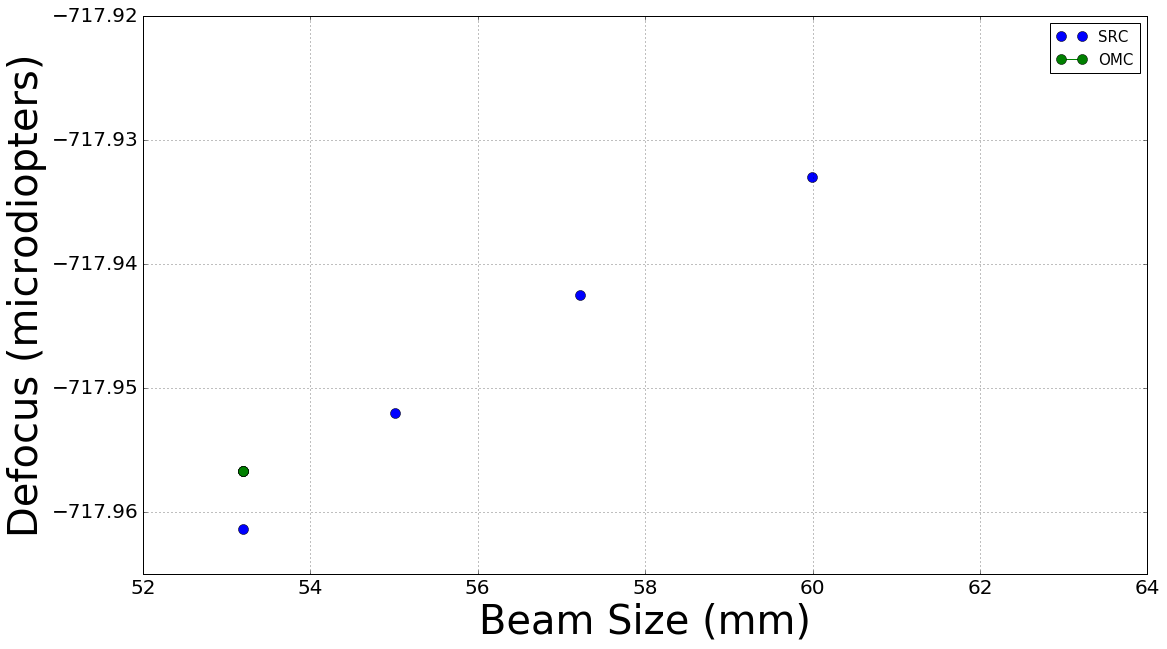

In [36]:
pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(111)

pl.plot(f_SRC_wx,f_SRC_sx,'o', markersize = 10,label='SRC')
pl.plot(f_OMC_wx,f_OMC_sx,'-o', markersize = 10,label='OMC')

pl.legend(fontsize=15)

pl.ticklabel_format(useOffset=False)
pl.xlabel("Beam Size (mm)",fontsize=40)
pl.ylabel("Defocus (microdiopters)",fontsize=40)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.grid()
pl.savefig("WSPhaseSpace_OMC_SRC_noSqz_wMM.png")

pl.show()



In [28]:
f_q_BS_SRCY_x

[(1355.15649200328+225.95789793595j),
 (1359.81862857474+211.938006474682j),
 (1364.55127410382+196.573535541838j),
 (1369.35604031732+179.507987866797j),
 (1374.23458844121+160.185157717759j)]

In [33]:
pykat.beam_param.overlap(f_q_BS_SRCY_x[4],f_q_BS_SRCY_x[0])

0.9686223755474104